# Image Processing with Python: Applications in Machine Learning Part 2

by: Jephraim C. Manansala | Published on https://jephraim-manansala.medium.com/

### How can image processing techniques be used to prepare data for a machine learning algorithm?

In this post, we will learn the step-by-step procedures on how to preprocess and prepare image datasets to extract quantifiable features that can be used for a machine learning algorithm. Techniques such as binarization, template matching, morphological operations, and blob detection will be used. This serves as a supplement to the image processing techniques used in my previous article. https://jephraim-manansala.medium.com/image-processing-with-python-applications-in-machine-learning-17d7aac6bc97

Let’s begin.

As usual, we import libraries such as `numpy`, `pandas`, and `matplotlib`. Additionally, we import specific functions from the `skimage`, `sklearn`, and `imblearn` library.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from skimage.io import imread, imshow
from skimage.feature import match_template, peak_local_max
from skimage.measure import label, regionprops
from skimage.morphology import erosion, dilation
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.util import invert
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler

import warnings 
warnings.filterwarnings('ignore')

Our objective is to properly label the pitch and the notes on a music sheet. We will have to extract quantifiable information from each note that will serve as the input for our machine learning algorithm. Let's tackle this step-by-step!


### STEP 1: Perform Exploratory Data Analysis (EDA)

We should always remember that EDA is an essential part of any data science project. Before developing the machine learning pipeline, we need to familiarize ourselves with the data — this includes its structure, formatting, and nuances. This is crucial to ensure that the project methodology that will be conceptualized is appropriate for the dataset at hand.

For this project, we are going to use this music sheet of the nursery rhyme 'Mary Had a Little Lamb' (Original Image Courtesy of musescore.com)

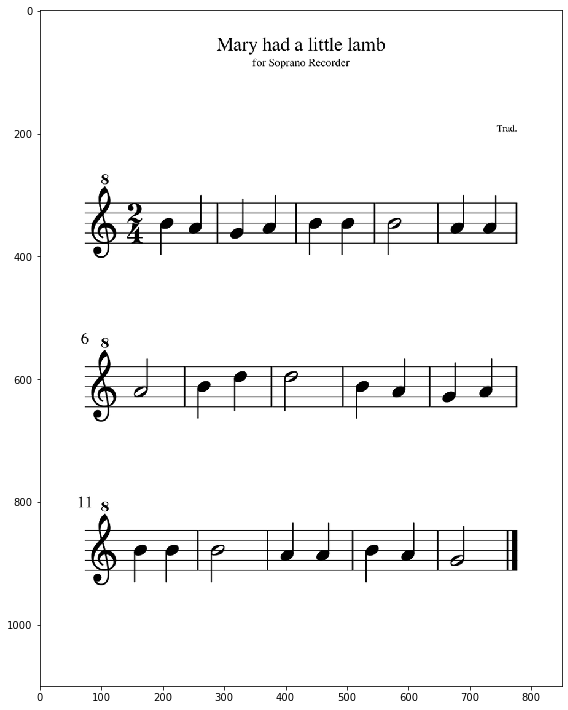

In [2]:
plt.figure(figsize=(8,15))
music = imread('music-sheet.png')
imshow(music);

Notice that we are only given one image of a music sheet. The image is a single-channel grayscale image, which means that we only need to binarize the image. Also, notice that each musical note has a specific symbol and position on it. This means that the machine learning pipeline to be developed should classify the musical symbol and the position of the said symbol. Lastly, notice that there is a G-cleft on each line on the musical sheet. We can use this as a reference point for each of the lines.

### STEP 2: Apply Image Binarization

From the EDA findings, we can start by performing image thresholding to extract the necessary information in the images. To do this, we will set all values above the midpoint as 255—meanwhile, all values below the midpoint as 0. 

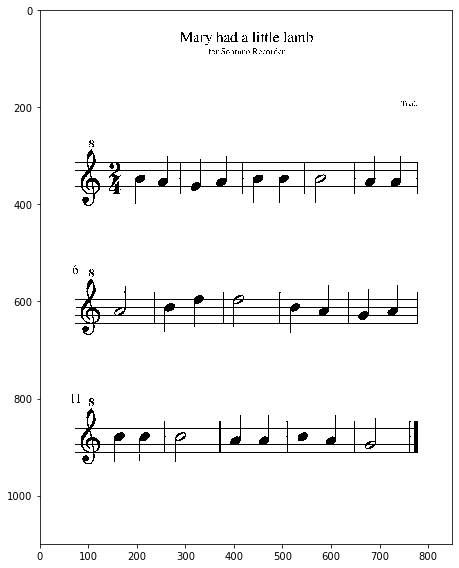

In [3]:
plt.figure(figsize=(8,8))
music[music<120]=0
music[music>=120]=255
imshow(music)

### STEP 3: Image Segmentation using Template Matching 

To help ease the image analysis, we should segment the image to every music line and remove unnecessary objects. From the EDA, we have observed that there is a G-clef on each of the music line. We can use this object as a reference point for each music line and use template matching (object detection) techniques. If you are not familiar with this technique, please do check it out in my previous post! https://jephraim-manansala.medium.com/image-processing-with-python-object-detection-using-template-matching-fa82b8c94fbd 

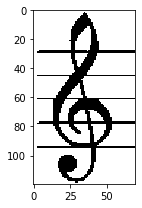

In [4]:
template = music[285:405, 70:140]
plt.figure(figsize=(3,3))
imshow(template);

Now, let's try to locate this template image to the input image!

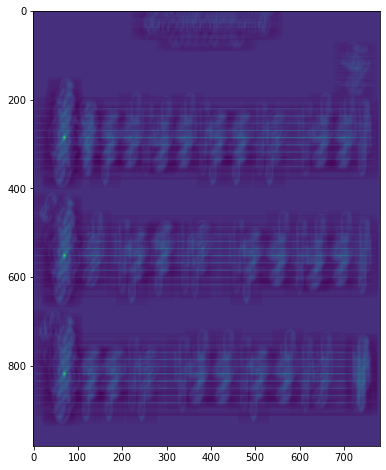

In [5]:
result = match_template(music, template)
plt.figure(figsize=(8,8))
plt.imshow(result, cmap='viridis'); 

Notice that the yellow spots on the resulting cross-correlation image? This signifies the areas where the image template matched the input image. We can see that the technique successfully identified the G-clefs' position in the input image. From here, we can segment the image using the coordinates of the matched template and add a range of values to encapsulate the entire staff lines.

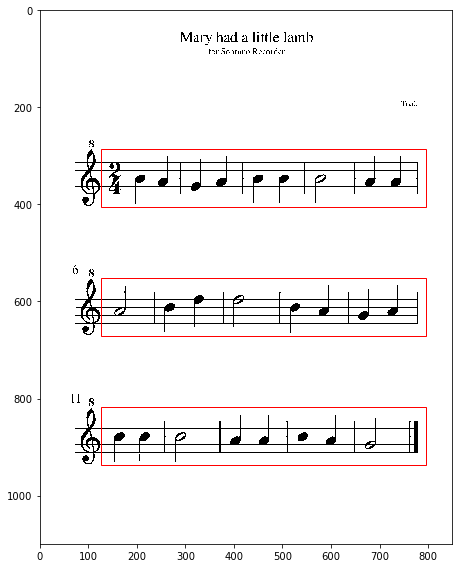

In [6]:
plt.figure(figsize=(8,8))
imshow(music)
template_height, template_width  = template.shape
music_lines = []

for y, x in peak_local_max(result, threshold_abs=0.8):
    rect = plt.Rectangle((x+55, y), 
                         template_width+600, 
                         template_height, 
                         color='r', 
                         fc='none')
    plt.gca().add_patch(rect);
    
    music_lines.append(music[y:y+template_height, 
                             x+55:x+template_width+600+55])

Notice how we did not encapsulate the G-clefs on the image segments? This is because we no longer need this symbol to determine each music notes' note and pitch. It has served its purpose of automatically encapsulating each line of the music sheet by detecting the G-clefs.

In [7]:
# fig, ax = plt.subplots(3,1, figsize=(15,8))
# ax[0].imshow(music_lines[0], cmap='gray')
# ax[1].imshow(music_lines[1], cmap='gray')
# ax[2].imshow(music_lines[2], cmap='gray')
# for a in ax.flatten():
#     a.axis('off')

### STEP 4: Apply Morphological Operations

The next step is to remove the staff lines from the resulting segmented music lines to focus on the musical notes and their position. We can do this by applying morphological operations to the image. Note that we will use a vertical structuring element to remove the horizontal lines on the image. 

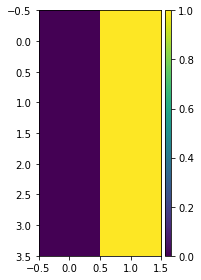

In [8]:
element = np.array([[0,1],
                    [0,1],
                    [0,1],
                    [0,1]])
imshow(element);

Using the vertical structuring element, we can now apply the dilation and erosion operations on the image.

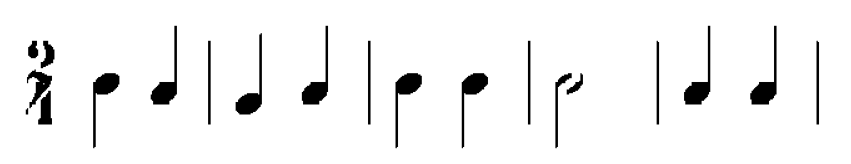

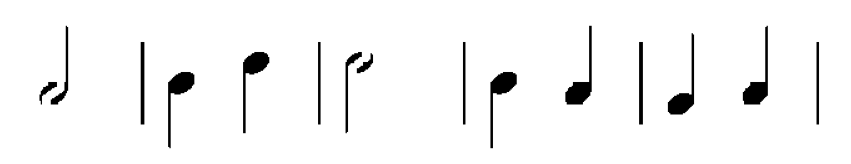

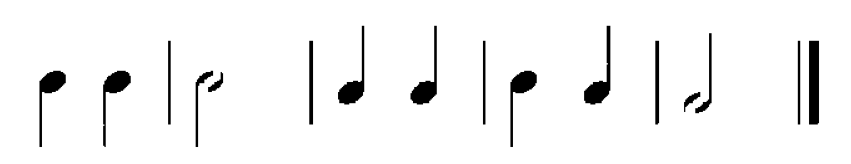

In [9]:
def remove_lines(image_used):
    dilated_image = dilation(image_used, element)
    eroded_image = erosion(dilated_image, element)
    
    plt.figure(figsize=(15,3))
    plt.imshow(eroded_image, cmap='gray');
    plt.axis('off')
    return eroded_image

line1 = remove_lines(music_lines[0])
line2 = remove_lines(music_lines[1])
line3 = remove_lines(music_lines[2])

Notice how the background is white, and the objects are black? This signifies that the background has the maximum value (255), while the objects have the minimum value (0). Because of this inversion, we will need to invert the functions of the morphological operations. Instead of applying erosion first, we will have to apply dilation (to remove the staff lines) prior to the erosion (to restore the remaining items' original shape).

###  STEP 5: Perform Blob Detection

Now that the staff lines are now removed, we can now apply blob detection to identify the notes' position. 

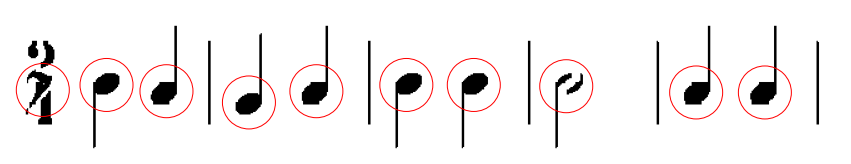

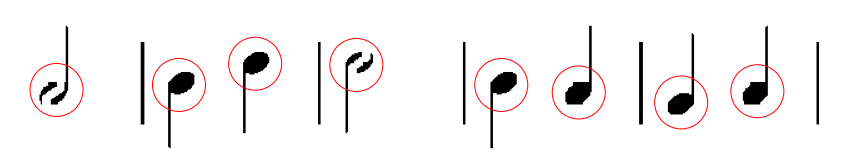

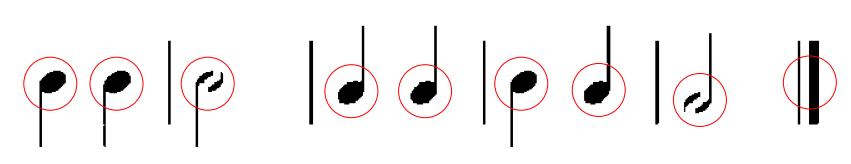

In [10]:
def blob_detection(eroded_image):
    blobs = blob_dog(invert(eroded_image), 
                     min_sigma=15, max_sigma = 20, threshold=0.70)

    fig, ax = plt.subplots( figsize=(15,3))
    ax.imshow(eroded_image, cmap='gray')
    ax.axis('off')
    for blob in blobs:
        y, x, area = blob
        ax.add_patch(plt.Circle((x, y), area*np.sqrt(2), color='r', 
                                fill=False))

    blobs = [(xaxis, yaxis) for yaxis, xaxis, z in blobs]
    blobs = sorted(blobs, key=lambda x: x[0])
    return blobs
blobs1 = blob_detection(line1)
blobs2 = blob_detection(line2)
blobs3 = blob_detection(line3)

For this step, I have opted to use blob detection using Difference of Gaussian rather than connected components because the objects I am trying to identify are not fully connected (specifically the 2-beat notes). Moreover, the blob detection algorithm will suffice to identify the blobs in this step because we only need the coordinates of each note's centroid to properly segment the musical symbols individually. 

### STEP 6: Pitch Evaluator

We can now determine each musical note's pitch from its relative position on the image segments' borders from the coordinates gathered in the blob detection. We do this by creating an if-else statement on the range of the centroids of each note. A deviation range, `dev`, is also created so that the algorithm has flexibility when the note is not centered correctly on the staff lines. 

PRO-TIP: When defining the range of values for each note, it will be easier to estimate this by using the axhline function in matplotlib to create a horizontal line on the image. 

In [11]:
def define_pitch(number, dev=4):
    if int(number) in range(11-dev, 11+dev):
        return "A"
    elif int(number) in range(19-dev, 19+dev): 
        return "G"
    elif int(number) in range(28-dev, 28+dev): 
        return "F"
    elif int(number) in range(36-dev, 36+dev): 
        return "E"
    elif int(number) in range(45-dev, 45+dev): 
        return "D"
    elif int(number) in range(53-dev, 53+dev): 
        return "C"
    elif int(number) in range(61-dev, 61+dev): 
        return "B"
    elif int(number) in range(69-dev, 69+dev): 
        return "A"
    elif int(number) in range(78-dev, 78+dev): 
        return "G"
    elif int(number) in range(86-dev, 86+dev): 
        return "F"
    elif int(number) in range(95-dev, 95+dev): 
        return "E"
    elif int(number) in range(104-dev, 104+dev): 
        return "D"
    elif int(number) in range(113-dev, 113+dev): 
        return "C"

Testing the created function, we have yielded the following results

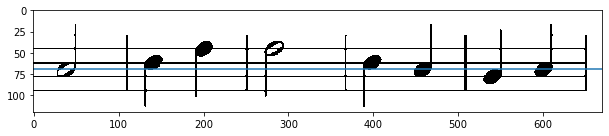

In [12]:
plt.figure(figsize=(15,2))
imshow(music_lines[1])
plt.axhline(69);

In [13]:
print([define_pitch(x[1]) for x in blobs2])

['A', 'B', 'D', 'D', 'B', 'A', 'G', 'A']


Note that this function works because we have fixed the image segmentation length and width on the algorithm. The pixel coordinate values set in the `define_pitch` function will not work on other image segmentation settings. 

###  STEP 7: Retrieve Object Properties using Connected Components

Now that we have determined the centroid of each of the musical symbols on the image, we can now segment each of these symbols individually. We can then apply the `regionprops` function to extract key features and properties on each of the symbols. We will be extracting the following properties on the symbols: 

1. `area` — Number of pixels of the region.
2. `convex_area` — Number of pixels of convex hull image, which is the smallest convex polygon that encloses the region.
3. `major_axis_length` — The length of the ellipse’s major axis has the same normalized second central moments as the region.
4. `minor_axis_length` — The length of the ellipse’s minor axis has the same normalized second central moments as the region.
5. `perimeter` — Perimeter of the object, which approximates the contour as a line through the centers of border pixels using a 4-connectivity.
6. `eccentricity` — Eccentricity of the ellipse that has the same second-moments as the region

These steps are automated on the function below:

In [14]:
def properties(regions):
    area= np.sum([x.area for x in regions])
    convex_area = np.sum([x.convex_area for x in regions]) 
    perimeter = np.sum([x.perimeter for x in regions]) 
    major_axis= np.mean([x.major_axis_length for x in regions]) 
    minor_axis = np.mean([x.minor_axis_length for x in regions]) 
    return {'area': area, 
            'convex_area': convex_area,
            'perimeter': perimeter,
            'major_axis': major_axis,
            'minor_axis': minor_axis}

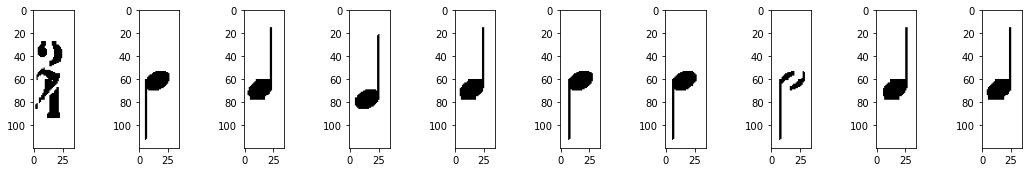

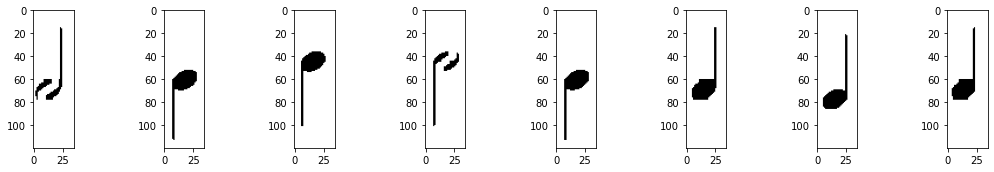

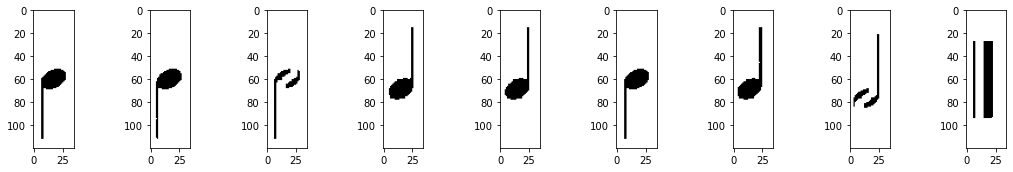

In [15]:
def blob_properties(eroded_image, blobs):
    fig, ax = plt.subplots(1, len(blobs), figsize=(15,2.5))

    props = {}
    for num, data in enumerate(blobs):
        columns=int(data[0])
        rows=int(data[1])
        new_image = eroded_image[:, columns-15:columns+20]
        
        label_im = label(invert(new_image))
        regions = regionprops(label_im)
        
        props[num] = properties(regions)
        
        ax[num].imshow(new_image, cmap='gray')
    return pd.DataFrame(props).T

props1 = blob_properties(line1, blobs1);
plt.tight_layout()
props2 = blob_properties(line2, blobs2);
plt.tight_layout()
props3 = blob_properties(line3, blobs3);
plt.tight_layout()

Now that we have collected each musical symbol's properties, we need to label each symbol to its appropriate classification manually. Note that we need not label all symbols. We just need enough so that the algorithm can learn which is which.

In [16]:
one_beat = pd.concat([props1.iloc[[1,2,3,4,5,6,8,9]], 
                      props2.iloc[[1,2,4,5,6,7]], 
                      props3.iloc[[0,1,3,4,5,6]]], axis=0)
one_beat['class'] = '1'
two_beat = pd.concat([props1.iloc[[7]], 
                      props2.iloc[[0,3]], 
                      props3.iloc[[2,7]]], axis=0)
two_beat['class'] = '2'
timesig = props1.iloc[[0]*2]
timesig['class'] = 'timesig'
end = props3.iloc[[8]*2]
end['class'] = 'end'

df = pd.concat([one_beat, two_beat, timesig, end])
df.sample(10)

,area,convex_area,perimeter,major_axis,minor_axis,class
3,254.0,571.0,186.183766,50.063308,8.176076,2
7,387.0,739.0,152.384776,62.427663,17.985528,1
6,430.0,798.0,154.284271,68.356221,18.034893,1
9,397.0,772.0,154.591883,62.811190,18.556140,1
7,245.0,563.0,181.597980,49.446556,7.972338,2
7,241.0,538.0,178.183766,47.266407,8.279556,2
1,381.0,772.0,148.698485,59.871782,18.972026,1
0,375.0,743.0,148.491378,60.847644,18.500701,1
3,381.0,785.0,157.455844,65.911883,18.796264,1
4,395.0,775.0,154.591883,62.852553,18.557397,1


Notice that we multiplied the number of items in the `timesig` and `end` objects. We did this to represent all objects in the train set and test set (later in the steps). 

### STEP 8:  Apply Feature Engineering

From the extracted features, we can further expand the features by deriving new features. We do this by getting the ratios of the extracted features together. Let’s try this!

In [17]:
def feature_engineering(df):
    df['ratio_length'] = df['minor_axis'] / df['major_axis']
    df['perimeter_ratio_major'] = df['perimeter'] / df['major_axis']
    df['perimeter_ratio_minor'] = df['perimeter'] / df['minor_axis']
    df['area_ratio_convex'] = df['area'] / df['convex_area']
    df['area_ratio_major'] = df['area'] / df['major_axis']
    df['area_ratio_minor'] = df['area'] / df['minor_axis']
    df['area_ratio_peri'] = df['area'] / df['perimeter']
    df['convex_ratio_major'] = df['convex_area'] / df['major_axis']
    df['convex_ratio_minor'] = df['convex_area'] / df['minor_axis']
    df['convex_ratio_peri'] = df['convex_area'] / df['perimeter']
    return df
final_df = feature_engineering(df)
final_df['class'] = df['class']

By doing so, we were able to expand our dataframe to 15 features!

### STEP 9: Split the Training and Test Set

The next step is to split the data from the dataframe of the extracted and derived features on the image data. This is critical to ensure that the machine learning model will have a set of “unseen” data to ensure that the training is not overfitting or underfitting. We do this using the `train_test_split` function in the `sklearn.model_selection` library. 

In [18]:
X = final_df.drop('class', axis=1)
y = final_df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    stratify = y)

In [19]:
y_train.value_counts()

1          14
2           4
timesig     1
end         1
Name: class, dtype: int64

### STEP 10:  Data Imbalance Handling

After splitting the dataset, we can notice that the number of object instances in each class is not equal. This can be a problem because this can lead to a bias to the majority class on the machine learning algorithm. To address this, we apply data imbalance handling using RandomOverSampler to ensure that the number of instances in each class is equal. Note that other data imbalance handling techniques can be used in this (such as RandomUnderSampler, SMOTE, or AdaSyn).

In [20]:
oversample = RandomOverSampler()
X_train, y_train = oversample.fit_resample(X_train, y_train)

### STEP 11: Train a Random Forest Classifier Model

Using the training dataset, we can now train a machine learning classifier model. We will be using a Random Forest Classifier because it is known to yield a high level of accuracy despite the simplicity of its algorithm. Note that since the Random Forest model is a tree-based model, we do not need to scale the dataset. However, if you will be using other machine learning models, you must scale the dataset's features.

In [25]:
RF = RandomForestClassifier(max_depth=5, n_estimators=500)
RF.fit(X_train, y_train)
y_pred_RF= RF.predict(X_test)

df = pd.DataFrame()

cols = ['Machine Learning Classification Method',
        'Train Accuracy', 
        'Test Accuracy', 
        "Top 1 Feature Predictor",
        "Top 2 Feature Predictor",
        "Top 3 Feature Predictor"]

df.loc['Machine Learning Classification Method', 
       'Details'] = 'Random Forest Classifier'
df.loc['Train Accuracy', 'Details'] = RF.score(X_train, y_train) 
df.loc['Test Accuracy', 'Details'] = RF.score(X_test, y_test)

importance = X.columns[np.argsort(RF.feature_importances_)][-3:]
df.loc['Top 1 Feature Predictor', 'Details'] = importance[2]
df.loc['Top 2 Feature Predictor', 'Details'] = importance[1]
df.loc['Top 3 Feature Predictor', 'Details'] = importance[0]

display(df)

,Details
Machine Learning Classification Method,Random Forest Classifier
Train Accuracy,1
Test Accuracy,1
Top 1 Feature Predictor,perimeter_ratio_minor
Top 2 Feature Predictor,convex_area
Top 3 Feature Predictor,convex_ratio_minor


The Random Forest Classifier yielded a test accuracy of 100%. The top features in classifying the different leaves are their `perimeter_ratio_minor`, `convex_area`,  and `convex_ratio_minor`. We can see that the convex_area, perimeter, and minor_axis are the primary features because of the musical symbols' distinct shapes. For example, the `1-beat note` has a greater convex_area because it covers a greater area, while the `2-beat note` has a greater perimeter because it has many regions. 

Awesome, right? Again, it is a model that is **both accurate and interpretable**! Now, the only thing left to do is to display the predicted musical note classification and pitch. 

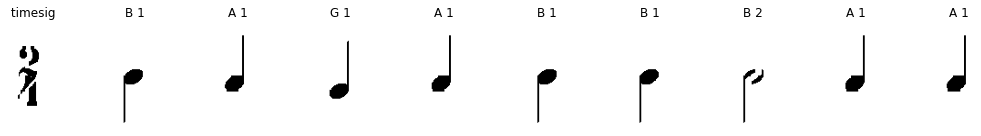

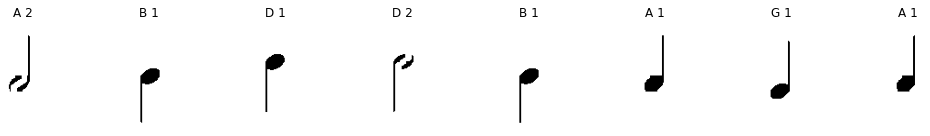

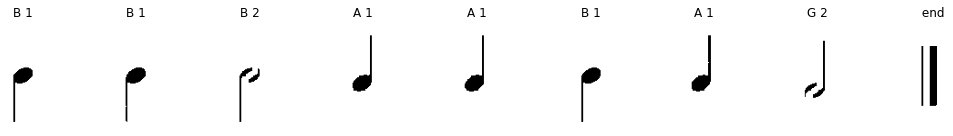

In [26]:
def blob_labeling(eroded_image, blobs):
    fig, ax = plt.subplots(1, len(blobs), figsize=(15,2))

    for num, data in enumerate(blobs):
        columns=int(data[0])
        rows=int(data[1])
        new_image = eroded_image[:, columns-15:columns+20]
        
        label_im = label(invert(new_image))
        regions = regionprops(label_im)
        
        dataset = pd.DataFrame([properties(regions)])
        final_df = feature_engineering(dataset)
        
        note = RF.predict(final_df)
        if (note[0] == '1') | (note[0] == '2'):
            pitch = define_pitch(rows)
        else:
            pitch = ''
        title = str(pitch + " " + str(note[0]))

        ax[num].imshow(new_image, cmap='gray')
        ax[num].axis('off')
        ax[num].set_title(title) 

props1 = blob_labeling(line1, blobs1);
plt.tight_layout()
props2 = blob_labeling(line2, blobs2);
plt.tight_layout()
props3 = blob_labeling(line3, blobs3);
plt.tight_layout()

#### In summary

We have explored how to use image processing techniques to prepare and preprocess image datasets to implement a machine learning algorithm. Using the `regionprops` function, we extracted valuable and quantifiable features from the image. Moreover, we have shown that preprocessing techniques such as binarization, template matching, morphological operations, and blob detection can be used to achieve our objective.

From this example, I hope you could appreciate how each technique can be used to manipulate the image to our advantage and how it can automate our procedures in creating a machine learning pipeline! 